# Analyzing the European Parliament

In [1]:
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as PathEffects
from matplotlib.ticker import FuncFormatter, FixedLocator

import bokeh.models as bmo
import bokeh.plotting as bpl
from bokeh.palettes import d3

import prince
import palettable

from tqdm.auto import tqdm

In [2]:
sns.set_context('talk')
bpl.output_notebook()

Loading BokehJS ...

## Download data

All data is readily available on [Parltrack](https://parltrack.org/).

In [3]:
# %%bash

# wget --no-clobber https://parltrack.org/dumps/ep_votes.json.lz
# lzip -d ep_votes.json.lz

# wget --no-clobber https://parltrack.org/dumps/ep_meps.json.lz
# lzip -d ep_meps.json.lz

## Transform JSON to dataframes

To easily work with the data, we transform it from JSON to pandas dataframes.

### MEPs

In [4]:
fname = 'ep_meps.json'

tmp = []
with open(fname) as fd:
    for line in tqdm(fd.readlines()):
        line = line.lstrip('[,]')
        if len(line) == 0:
            continue

        data = json.loads(line)

        #         if not data['active']:
        #             continue

        tmp.append(
            {
                'UserID': data['UserID'],
                'name': data['Name']['full'],
                'birthday': data['Birth']['date'] if 'Birth' in data else np.nan,
                'active': data['active'],
                'group': data.get('Groups', [{'groupid': np.nan}])[-1][
                    'groupid'
                ],  # assumption: last group is latest one. Is this true?
            }
        )

  0%|          | 0/4150 [00:00<?, ?it/s]

In [5]:
df_meps = pd.DataFrame(tmp)
df_meps['birthday'] = pd.to_datetime(df_meps['birthday'])

df_meps.set_index('UserID', inplace=True)

df_meps['group'].replace(
    {'Group of the European United Left - Nordic Green Left': 'GUE/NGL'}, inplace=True
)  # is there a difference?

df_meps.head()

name   birthday  active group
UserID                                                          
2307                      Hubert PIRKER 1948-10-03   False   PPE
111496  María Auxiliadora CORREA ZAMORA 1972-05-24   False   PPE
110987                  Gino TREMATERRA 1940-09-03   False   PPE
1965                         Jan MULDER 1943-10-03   False  ALDE
39321       Vicente Miguel GARCÉS RAMÓN 1946-11-10   False   S&D

### Votes

In [6]:
fname = 'ep_votes.json'

tmp = []
tmp_matrix = {}
with open(fname) as fd:
    for line in tqdm(fd.readlines()):
        line = line.lstrip('[,]')
        if len(line) == 0:
            continue

        data = json.loads(line)
        tmp.append(
            {'date': data['ts'], 'voteid': data['voteid'], 'title': data['title']}
        )

        if 'votes' in data:
            tmp_matrix[data['voteid']] = {
                **{
                    mep['mepid']: '+'
                    for mep_list in data['votes']
                    .get('+', {'groups': {'foo': []}})['groups']
                    .values()
                    for mep in mep_list
                    if 'mepid' in mep
                },
                **{
                    mep['mepid']: '-'
                    for mep_list in data['votes']
                    .get('-', {'groups': {'foo': []}})['groups']
                    .values()
                    for mep in mep_list
                    if 'mepid' in mep
                },
                **{
                    mep['mepid']: '0'
                    for mep_list in data['votes']
                    .get('0', {'groups': {'foo': []}})['groups']
                    .values()
                    for mep in mep_list
                    if 'mepid' in mep
                },
            }

  0%|          | 0/23906 [00:00<?, ?it/s]

In [7]:
df_votematrix = pd.DataFrame.from_dict(tmp_matrix, orient='index')

df_votematrix.index.name = 'voteid'
df_votematrix.columns.name = 'mepid'

# df_votematrix.sort_values('voteid', axis=0, inplace=True)
df_votematrix.sort_values('mepid', axis=1, inplace=True)

df_votematrix.head()

mepid  1      234    684    729    840    945    966    988    997    1002    \
voteid                                                                         
7754      NaN    NaN      +      +    NaN    NaN    NaN    NaN    NaN    NaN   
7818        -      +      -      -    NaN      -    NaN    NaN      +      -   
7759        +      +      +      +    NaN      +      +    NaN      +    NaN   
7755      NaN      0      +    NaN    NaN      +      0    NaN      +      +   
7760        -      -      -      -    NaN      -      +    NaN      +      -   

mepid   ... 204416 204418 204419 204420 204421 204443 204449 204733 205452  \
voteid  ...                                                                  
7754    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7818    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7759    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7755    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7760    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

mepid  206158  
voteid         
7754      NaN  
7818      NaN  
7759      NaN  
7755      NaN  
7760      NaN  

[5 rows x 2329 columns]

In [8]:
df_votes = pd.DataFrame(tmp)
df_votes['date'] = pd.to_datetime(df_votes['date'])

df_votes.set_index('voteid', inplace=True)

df_votes.tail()

date                      title
voteid                                               
116359 2020-07-23 12:49:32       B9-0229/2020 - Am 23
116398 2020-07-23 12:49:32      B9-0229/2020 - § 26/1
116399 2020-07-23 12:49:32      B9-0229/2020 - § 26/2
116360 2020-07-23 12:49:32        B9-0229/2020 - Am 1
116401 2020-07-23 16:52:06  B9-0229/2020 - Résolution

## Exploration

We can then look at a few simple statistics.

### MEP party distribution

How many members (MEPs) does each party of the European parliament have?

In [9]:
df_meps['active'].sum()

705

(-1.1107175100739686,
 1.1005103586792213,
 -1.1057638158926402,
 1.1094386022707399)

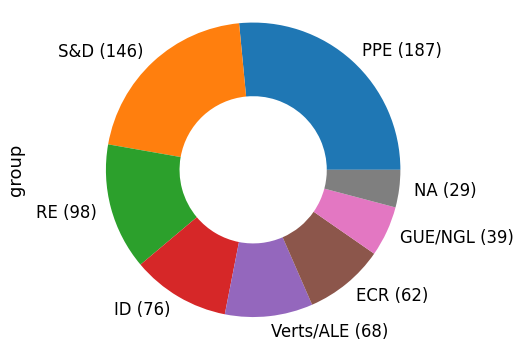

In [10]:
group_counts = df_meps.loc[df_meps['active'], 'group'].value_counts()
labels = group_counts.to_frame().apply(lambda x: f'{x.name} ({x.iloc[0]})', axis=1)

ax = group_counts.plot.pie(figsize=(8, 6), labels=labels, wedgeprops=dict(width=0.5))
ax.axis('equal')

### MEP age distribution

And how old are these members?

In [11]:
df_meps['age'] = (pd.Timestamp.today() - df_meps['birthday']) / np.timedelta64(1, 'Y')

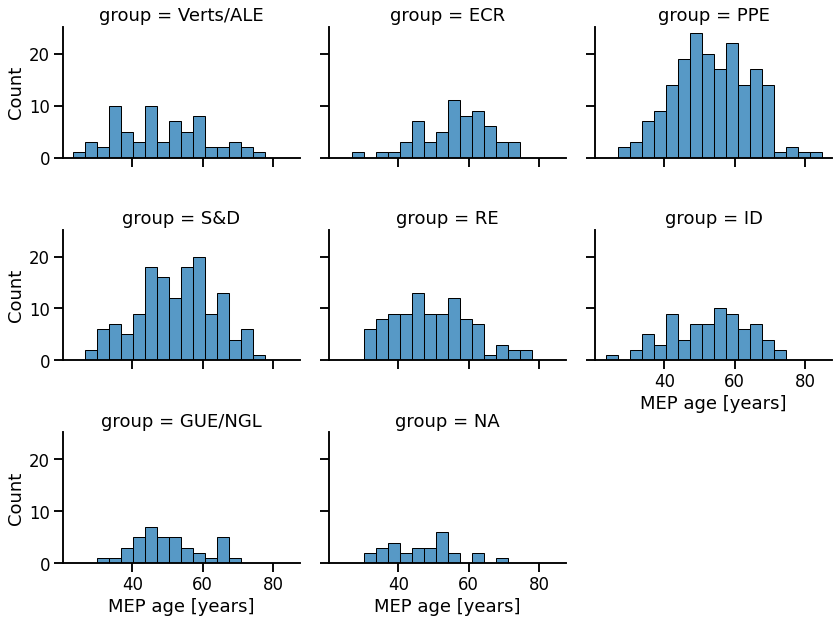

In [12]:
g = sns.displot(
    data=df_meps[df_meps['active']],
    x='age',
    col='group',
    col_wrap=3,
    height=3,
    aspect=4 / 3,
)

g.set_xlabels('MEP age [years]')

## Voting patterns

Let's now take a look at how these MEPs vote.

In [13]:
df_votematrix.head()

mepid  1      234    684    729    840    945    966    988    997    1002    \
voteid                                                                         
7754      NaN    NaN      +      +    NaN    NaN    NaN    NaN    NaN    NaN   
7818        -      +      -      -    NaN      -    NaN    NaN      +      -   
7759        +      +      +      +    NaN      +      +    NaN      +    NaN   
7755      NaN      0      +    NaN    NaN      +      0    NaN      +      +   
7760        -      -      -      -    NaN      -      +    NaN      +      -   

mepid   ... 204416 204418 204419 204420 204421 204443 204449 204733 205452  \
voteid  ...                                                                  
7754    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7818    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7759    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7755    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7760    ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

mepid  206158  
voteid         
7754      NaN  
7818      NaN  
7759      NaN  
7755      NaN  
7760      NaN  

[5 rows x 2329 columns]

### Who is the most active MEP?

Here we equate "active" with "has voted most often". This is most likely quite misleading.

In [14]:
df_hasvoted = ~df_votematrix[df_meps[df_meps['active']].index].isna()

In [15]:
df_hasvoted.sum(axis=0).sort_values(ascending=False).to_frame('vote_count').merge(
    df_meps, how='left', left_index=True, right_index=True
).head(10)

vote_count                 name   birthday  active group        age
mepid                                                                     
28266       22954    Sophia in 't VELD 1963-09-13    True    RE  57.711345
1913        22703     Evelyne GEBHARDT 1954-01-19    True   S&D  67.359729
2323        22394       Rainer WIELAND 1957-02-19    True   PPE  64.274108
4246        22324         Othmar KARAS 1957-12-24    True   PPE  63.430833
28219       22324       Daniel CASPARY 1976-04-04    True   PPE  45.152566
2341        22269       Michael GAHLER 1960-04-22    True   PPE  61.103612
28224       22164        Markus PIEPER 1963-05-15    True   PPE  58.042632
28298       21992  Iratxe GARCÍA PÉREZ 1974-10-07    True   S&D  46.644725
23821       21912        József SZÁJER 1961-09-07    True   PPE  59.726445
28223       21910       Andreas SCHWAB 1973-04-09    True   PPE  48.139622

### Select subset of data

For the subsequent vote clustering, we restrict ourselves to recent votes of active MEPs starting with 2020 (and remove MEPs with no votes at all).

In [16]:
df_subset = df_votematrix.loc[
    df_votematrix.index.intersection(df_votes[df_votes['date'] > '2020'].index),
    df_meps[df_meps['active']].index,
].dropna(how='all', axis=1)

print(df_subset.shape)
df_subset.head()

(1808, 703)


UserID 96750  4746   23788  96810  96808  4560   38595  1992   125106 4391    \
voteid                                                                         
111241      0    NaN    NaN    NaN      +    NaN    NaN    NaN      +    NaN   
111141      +    NaN    NaN      +      +      +    NaN    NaN      +    NaN   
111142      +    NaN    NaN      +      +      +    NaN      +      +    NaN   
111143      +    NaN    NaN      +      +      +    NaN      +      +    NaN   
111781      -    NaN    NaN      +      -      -    NaN      -      +    NaN   

UserID  ... 204413 204334 204331 204346 204449 204400 197780 204733 205452  \
voteid  ...                                                                  
111241  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
111141  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
111142  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
111143  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
111781  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

UserID 206158  
voteid         
111241    NaN  
111141    NaN  
111142    NaN  
111143    NaN  
111781    NaN  

[5 rows x 703 columns]

### Clustered data overview

Here, we cluster both MEPs and votes as well as highlight each MEP column with their respective party association.

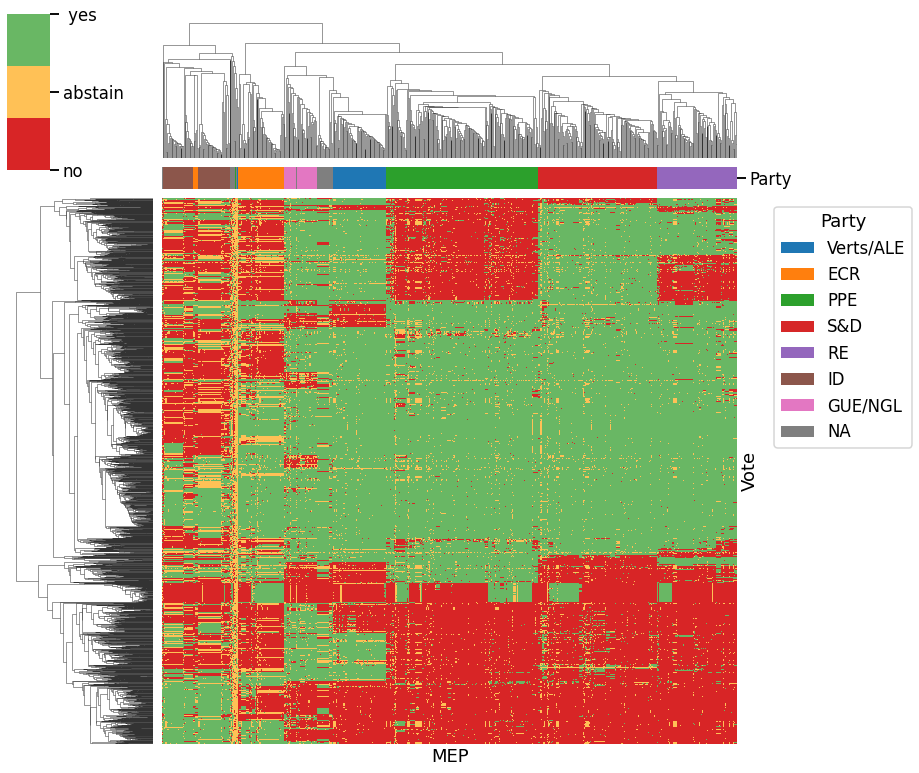

In [17]:
# process data to work with clustermap
tmp = df_subset.fillna(0).replace({'+': 1, '0': 0, '-': -1})  # .iloc[:10, :10]
tmp.columns.rename('MEP', inplace=True)
tmp.index.rename('Vote', inplace=True)

# infer party colors
party_colors = {
    party: sns.color_palette('tab10')[i]
    for i, party in enumerate(df_meps.loc[tmp.columns, 'group'].unique())
}
party_cmap = (
    tmp.T.merge(df_meps['group'], how='inner', left_index=True, right_index=True)[
        'group'
    ]
    .map(party_colors)
    .rename('Party')
)

# main plot
g = sns.clustermap(
    tmp,
    col_colors=party_cmap,
    cmap=palettable.tableau.TrafficLight_9.hex_colors[3:6],
    figsize=(12, 12),
)

# plot improvements
g.ax_heatmap.tick_params(bottom=False, labelbottom=False, right=False, labelright=False)


@FuncFormatter
def formatter(x, pos):
    return {-1: 'no', 0: 'abstain', 1: ' yes'}[x]


g.cax.yaxis.set_major_locator(FixedLocator([-1, 0, 1]))
g.cax.yaxis.set_major_formatter(formatter)

# party color legend
g.ax_heatmap.legend(
    handles=[
        Patch(facecolor=color, label=name) for name, color in party_colors.items()
    ],
    title='Party',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
)

# TODO: improve overall colorbar/legend placement

### Project MEPs based on vote patterns

We will now visualize the landscape of MEPs in two dimensions based on the voting patterns using Multiple Correspondence Analysis.

#### Apply Multiple Correspondence Analysis (MCA)

In [18]:
mca = prince.MCA(n_components=2)
df_mca = mca.fit_transform(df_subset.T)

df_mca.columns = ('MCA0', 'MCA1')
df_mca.index.rename('mepid', inplace=True)
df_mca['group'] = df_meps.loc[df_meps['active'], 'group']

print(df_mca.shape)
df_mca.head()

(703, 3)


MCA0      MCA1      group
mepid                               
96750 -0.371809  0.631197  Verts/ALE
4746   0.593274 -0.471376        ECR
23788  0.398250 -0.753624        ECR
96810  0.604044 -0.488594        ECR
96808 -0.231881 -0.476251        PPE

#### Static visualization

In [19]:
# obtained from the information box on each party's Wikipedia entry
party_ideology = {
    'Verts/ALE': 'green',
    'ECR': 'conservative',
    'PPE': 'liberal\nconservative',
    'S&D': 'socialist',
    'RE': 'liberal',
    'ID': 'right-wing',
    'GUE/NGL': 'left-wing',
}

Text(0.5, 1.0, 'MCA of MEP Voting Patterns')

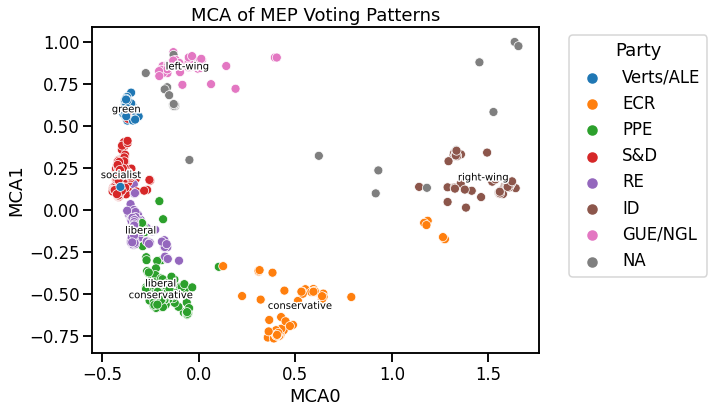

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(data=df_mca, x='MCA0', y='MCA1', hue='group', ax=ax)

for party, row in df_mca.groupby('group').mean().iterrows():
    if party == 'NA':
        continue
    ax.text(
        row.MCA0,
        row.MCA1,
        party_ideology.get(party),
        ha='center',
        va='center',
        fontsize=10,
        path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")],
    )

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1, title='Party')
ax.set_title('MCA of MEP Voting Patterns')

#### Interactive visualization

You can zoom and pan the visualization. Hovering over each point (corresponding to a MEP) will display relevant information.

In [21]:
# generate data for each tooltip
hover_data = df_meps.loc[df_mca.index]

hover_data['name'] = hover_data['name'].str.title()
hover_data['birthday'] = hover_data['birthday'].apply(
    lambda x: x.strftime("%Y-%m-%d") if not pd.isnull(x) else 'undef'
)
hover_data['age'] = hover_data['age'].apply(
    lambda x: int(x) if not pd.isnull(x) else -1
)

df_data = df_mca.merge(
    hover_data.drop('group', axis=1), left_index=True, right_index=True
)
df_data.head()

MCA0      MCA1      group                    name    birthday  \
mepid                                                                      
96750 -0.371809  0.631197  Verts/ALE        François Alfonsi  1953-09-14   
4746   0.593274 -0.471376        ECR          Sergio Berlato  1959-07-27   
23788  0.398250 -0.753624        ECR             Adam Bielan  1974-09-12   
96810  0.604044 -0.488594        ECR           Carlo Fidanza  1976-09-21   
96808 -0.231881 -0.476251        PPE  Pablo Arias Echeverría  1970-06-30   

       active  age  
mepid               
96750    True   67  
4746     True   61  
23788    True   46  
96810    True   44  
96808    True   50

In [22]:
# set up point colors
palette = d3['Category10'][df_data['group'].nunique()]
color_map = bmo.CategoricalColorMapper(
    factors=df_data['group'].unique(), palette=palette
)

In [23]:
# create figure
p = bpl.figure(
    tools='hover,pan,reset,wheel_zoom,box_zoom',
    active_scroll='wheel_zoom',
    tooltips=[(col, f'@{col}') for col in hover_data],
    background_fill_color='black',
)

p.scatter(
    x='MCA0',
    y='MCA1',
    color={'field': 'group', 'transform': color_map},
    legend_field='group',
    size=5,
    source=df_data,
)

p.grid.visible = False
p.axis.visible = False

bpl.show(p)